# Fred Burst, Task 1
## Propagate variance from the telluric correction
### Part 1- Progate variance and save everything to an HDF5 file

Michael Gully-Santiago  
Wednesday, December 2, 2015  


Blindly dividing by the telluric correction is "good enough".

So in this notebook, we just have to perform the division, propagate the uncertainty, and save the file to the desired format.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
hdu_raw = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.spec.fits')
hdu_f   = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.spec_flattened.fits')
hdu_var = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0067.variance.fits')
hdu_tar = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0063.spec.fits')
tar_var = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCH_20151022_0063.variance.fits')
hdr = hdu_tar[0].header

## The problem: Propagating uncertainty

We are performing:  
$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} $$

The net uncertainty is given by:

$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 }$$

In [4]:
f_star = hdu_tar[0].data/hdu_raw[0].data

In [5]:
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = np.abs(f_star * np.sqrt( term1 + term2 ))

In [6]:
np.std(sig_star[sig_star == sig_star])

6754951.5

(array([     0.,  12859.,  10471.,   4553.,   2566.,   2033.,   1470.,
          1073.,    917.,    806.,    666.,    528.,    510.,    504.,
           431.,    412.,    408.,    315.,    325.,    311.,    259.,
           229.,    226.,    217.,    190.,    173.,    148.,    149.,
           148.,    177.]),
 array([ 0.        ,  0.00333333,  0.00666667,  0.01      ,  0.01333333,
         0.01666667,  0.02      ,  0.02333333,  0.02666667,  0.03      ,
         0.03333333,  0.03666667,  0.04      ,  0.04333333,  0.04666667,
         0.05      ,  0.05333333,  0.05666667,  0.06      ,  0.06333333,
         0.06666667,  0.07      ,  0.07333333,  0.07666667,  0.08      ,
         0.08333333,  0.08666667,  0.09      ,  0.09333333,  0.09666667,
         0.1       ]),
 <a list of 30 Patch objects>)

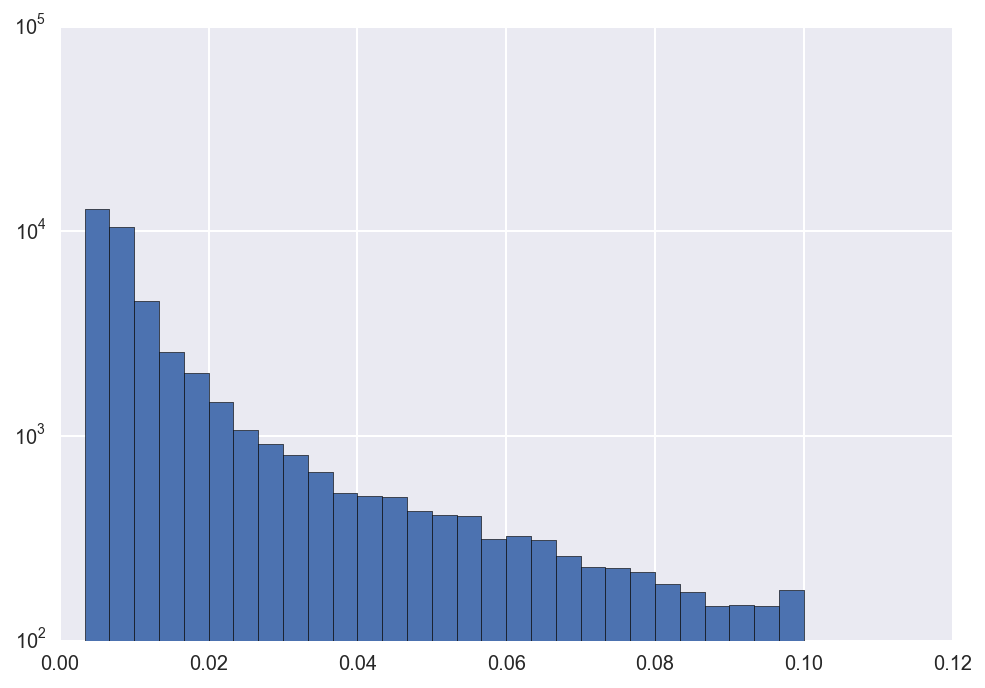

In [7]:
plt.hist(sig_star[sig_star == sig_star], bins=30, range=(0, 0.1), log=True)

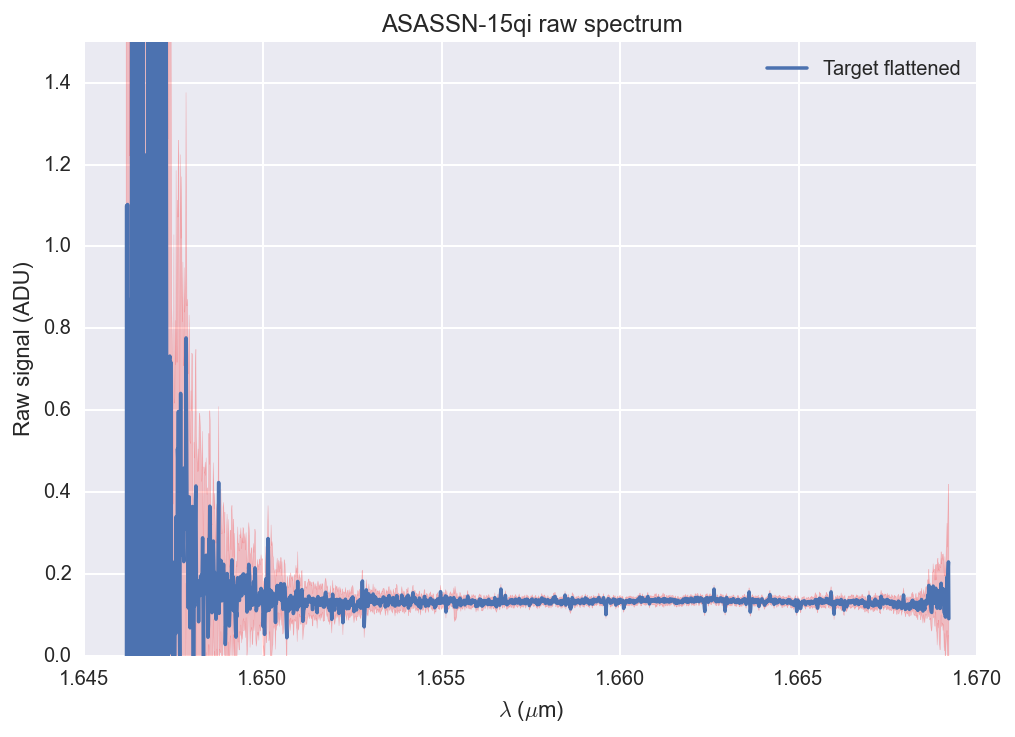

In [8]:
o=10
plt.plot(hdu_tar[1].data[o, :], f_star[o, :], label='Target flattened')
plt.fill_between(hdu_raw[1].data[o, :], f_star[o, :] - 1.96 * sig_star[o, :], f_star[o, :] + 1.96 * sig_star[o, :],
                alpha=0.2, color='r', label='95% confidence interval')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.ylim(0, 1.5)
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));


**Figure 1:** Stellar target spectrum corrected for the spectral response function- both instrumental response and telluric absorption lines.  The pink contour shows the 95% confidence interval.

## Save the file format
We want HDF5, actually...

Normalize by the median.

In [9]:
med_f_star = np.nanmedian(f_star)

In [10]:
f_star = f_star / med_f_star
sig_star = sig_star / med_f_star

Do some data munging.

In [11]:
wavelength_angstrom = hdu_tar[1].data*10000.0

In [12]:
masks = (f_star != f_star) | ((sig_star != sig_star))

In [13]:
f_star[masks] = 0.5

In [14]:
sig_star[masks] = 10.0

In [15]:
# masks.sum()

In [16]:
masks.astype(int)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [17]:
import h5py

In [18]:
f = h5py.File("../data/reduced/ASASSN15qi_IGRINS_H.hdf5", "w")
dset1 = f.create_dataset('wls', data=wavelength_angstrom) #Angstroms
dset2 = f.create_dataset('fls', data=f_star)
dset3 = f.create_dataset('sigmas', data=sig_star)
dset4 = f.create_dataset('masks', data=masks.astype(int))
f.close()

## The end.